In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
f = '../data/002_processed/slp.parquet'
slp = pd.read_parquet(f)
print(slp.factor_sem.sum())
slp.dropna(inplace=True)
print(slp.factor_sem.sum())

599165
438227


In [3]:
slp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 576 entries, 20672 to 21602
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   factor_sem  576 non-null    int64  
 1   total_niv   576 non-null    int64  
 2   tot_cuart   576 non-null    int64  
 3   tot_integ   576 non-null    int64  
 4   m2          576 non-null    float64
 5   estrato     576 non-null    object 
 6   kwh_mes     576 non-null    float64
 7   kwh_m2      576 non-null    float64
dtypes: float64(3), int64(4), object(1)
memory usage: 40.5+ KB


In [4]:
f = "../data/001_raw/ENCEVI_2018/aireacond.csv"
aire = pd.read_csv(f,index_col=0)

folios_con_ac = aire.index.unique()

slp_aa = slp.loc[ slp.index.isin(folios_con_ac) ]

# 3. Subconjunto de viv sin AC
slp_naa = slp.loc[ ~slp.index.isin(folios_con_ac) ]

# 4. Comprobar tamaños
print("Con AC:", slp_aa.shape)
print("Sin AC:", slp_naa.shape)

Con AC: (31, 8)
Sin AC: (545, 8)


In [5]:
slp.m2.unique()

array([150.,  55.,  75., 100.,  30., 200.])

In [6]:

# ---- utilidades ----
def _percentiles_ponderados(x, w, qs=(25, 50, 75)):
    x = np.asarray(x, float)
    w = np.asarray(w, float)
    m = np.isfinite(x) & np.isfinite(w) & (w > 0)
    if not np.any(m):
        raise ValueError("No hay datos válidos o la suma de pesos es cero.")
    x, w = x[m], w[m]
    o = np.argsort(x)
    x, w = x[o], w[o]
    cw = np.cumsum(w) / w.sum()
    qs = np.asarray(qs, float) / 100.0
    return np.interp(qs, cw, x)

def _weighted_fd_bin_edges(x, w, max_bins=200):
    q25, q75 = _percentiles_ponderados(x, w, (25, 75))
    iqr = q75 - q25
    x_min, x_max = float(np.min(x)), float(np.max(x))
    if (not np.isfinite(iqr)) or iqr <= 0 or (x_min == x_max):
        k = int(np.ceil(np.sqrt(len(x))))
        k = max(1, min(k, max_bins))
        return np.linspace(x_min, x_max if x_max > x_min else x_min + 1.0, k + 1)
    n_eff = (w.sum() ** 2) / np.sum(w ** 2)
    h = 2 * iqr / (n_eff ** (1/3))
    k = int(np.ceil((x_max - x_min) / h)) if (np.isfinite(h) and h > 0) else int(np.ceil(np.sqrt(len(x))))
    k = max(1, min(k, max_bins))
    return np.linspace(x_min, x_max, k + 1)

def grafica_kwh_mes_por_m2(
    slp,
    tot_integ: int,
    m2_value,
    columna_valor: str = "kwh_mes",
    columna_peso: str = "factor_sem",
    columna_m2: str = "m2",
    bins="fd",                       # int | array de bordes | "fd"/"auto"
    ax=None,
    titulo_prefix="Distribución kWh/mes",
):
    """
    Filtra por (tot_integ, m2_value), grafica histograma ponderado
    y regresa p25/p50/p75 ponderados junto con N y peso_total.
    """
    cols = [columna_valor, columna_peso, columna_m2, "tot_integ"]
    df = slp.loc[
        (slp["tot_integ"].eq(tot_integ)) &
        (slp[columna_m2].eq(m2_value)),
        cols
    ].dropna()

    if df.empty:
        raise ValueError("Sin filas tras el filtro. Revisa tot_integ o m2_value.")

    x = df[columna_valor].to_numpy(float)
    w = df[columna_peso].to_numpy(float)

    p25, p50, p75 = _percentiles_ponderados(x, w, (25, 50, 75))

    # bins compatibles con weights
    if isinstance(bins, (int, np.integer)) or np.ndim(bins) == 1:
        edges = bins
    elif isinstance(bins, str):
        edges = _weighted_fd_bin_edges(x, w)
    else:
        edges = 30

    # plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(7.2, 4.5))

    w_norm = w / w.sum()
    ax.hist(x, bins=edges, weights=w_norm, edgecolor="white")
    ax.set_xlabel(columna_valor)
    ax.set_ylabel("Proporción ponderada")
    ax.set_title(
        f"{titulo_prefix} — tot_integ: {tot_integ}, m2: {m2_value}\n"
        f"N={len(x)} | peso_total={w.sum():.0f}"
    )

    for val, lab in [(p25, "p25"), (p50, "p50 (mediana)"), (p75, "p75")]:
        ax.axvline(val, linestyle="--", linewidth=2)
        ymax = ax.get_ylim()[1]
        ax.text(val, ymax * 0.97, f"{lab} = {val:.1f}", rotation=90, va="top", ha="right")

    plt.tight_layout()
    print ( {
        "p25": float(p25),
        "p50": float(p50),
        "p75": float(p75),
        "n": int(len(x)),
        "peso_total": float(w.sum()),
        "m2": float(m2_value),
    } )


{'p25': 18.540580626300475, 'p50': 40.67709129220528, 'p75': 53.1774541290079, 'n': 24, 'peso_total': 16540.0, 'm2': 55.0}
{'p25': 36.691495707333225, 'p50': 53.253354818710946, 'p75': 70.57132161988304, 'n': 18, 'peso_total': 13506.0, 'm2': 75.0}
{'p25': 41.406616469182964, 'p50': 51.30011584152288, 'p75': 87.87139659085366, 'n': 30, 'peso_total': 27069.0, 'm2': 100.0}


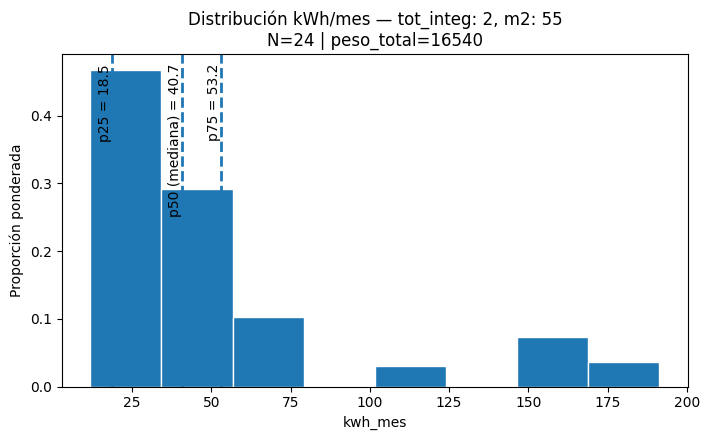

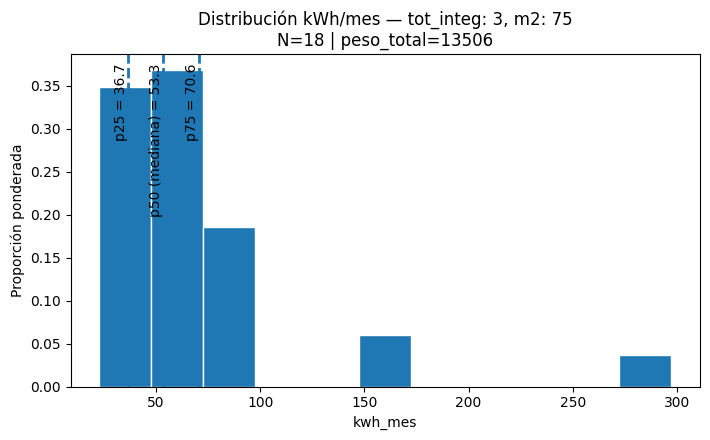

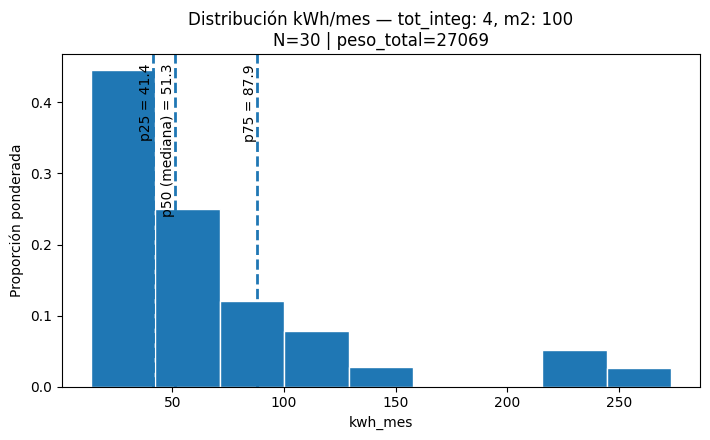

In [7]:
grafica_kwh_mes_por_m2(slp_naa,tot_integ=2,m2_value=55)
grafica_kwh_mes_por_m2(slp_naa,tot_integ=3,m2_value=75)
grafica_kwh_mes_por_m2(slp_naa,tot_integ=4,m2_value=100)

{'p25': 66.34751651612905, 'p50': 66.34751651612905, 'p75': 66.34751651612905, 'n': 1, 'peso_total': 1088.0, 'm2': 55.0}
{'p25': 467.6904762, 'p50': 467.6904762, 'p75': 467.6904762, 'n': 1, 'peso_total': 979.0, 'm2': 100.0}


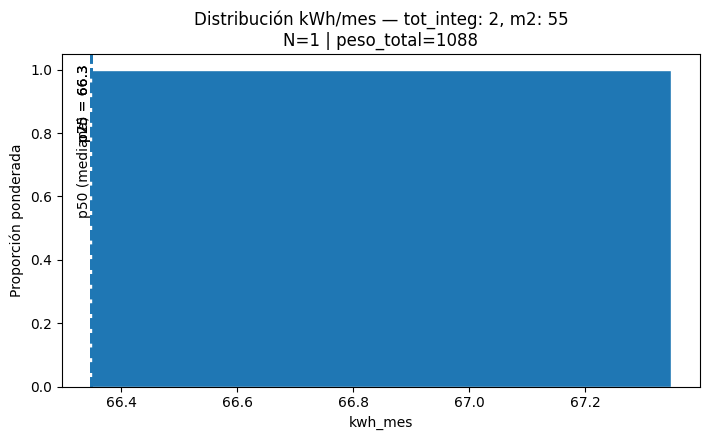

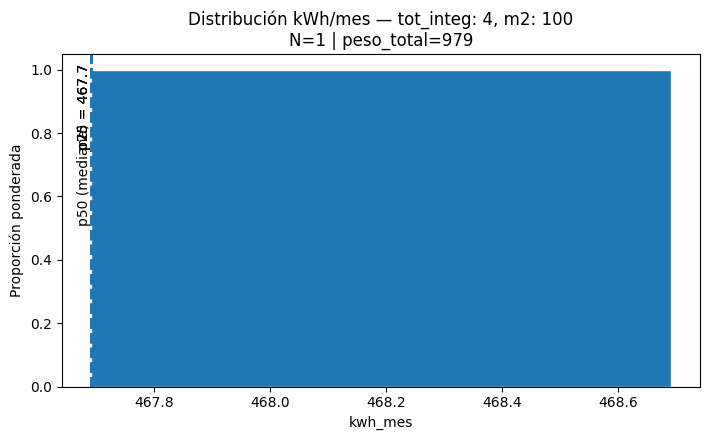

In [8]:
grafica_kwh_mes_por_m2(slp_aa,tot_integ=2,m2_value=55)
# grafica_kwh_mes_por_m2(slp_aa,tot_integ=3,m2_value=75) 
grafica_kwh_mes_por_m2(slp_aa,tot_integ=4,m2_value=100)

{'p25': 20.128623131833084, 'p50': 41.61279620772455, 'p75': 63.97350696080578, 'n': 25, 'peso_total': 17628.0, 'm2': 55.0}
{'p25': 36.691495707333225, 'p50': 53.253354818710946, 'p75': 70.57132161988304, 'n': 18, 'peso_total': 13506.0, 'm2': 75.0}
{'p25': 41.44831143288551, 'p50': 51.8172957567918, 'p75': 93.76468851520278, 'n': 31, 'peso_total': 28048.0, 'm2': 100.0}


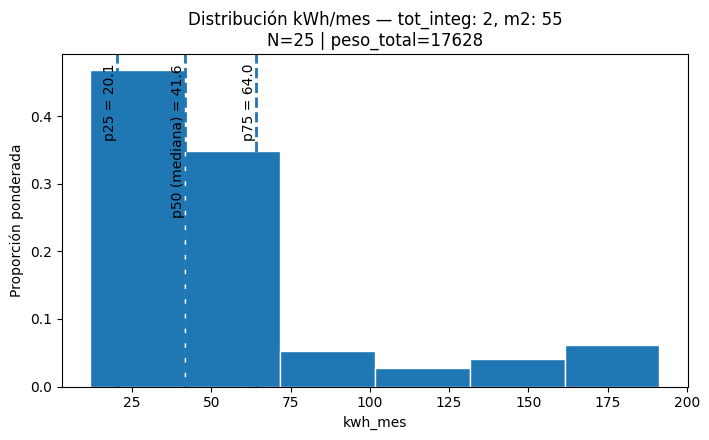

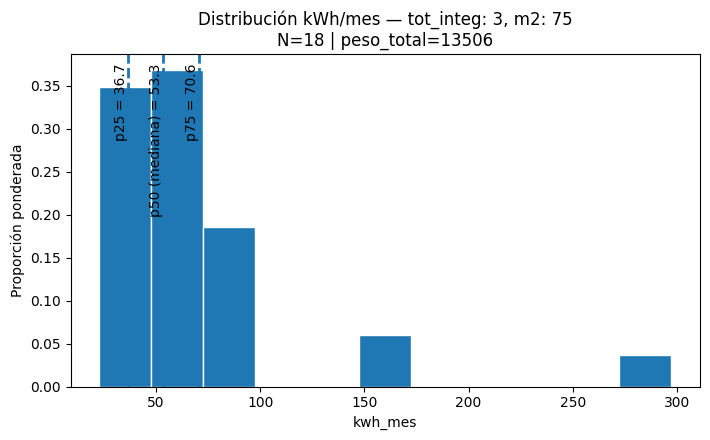

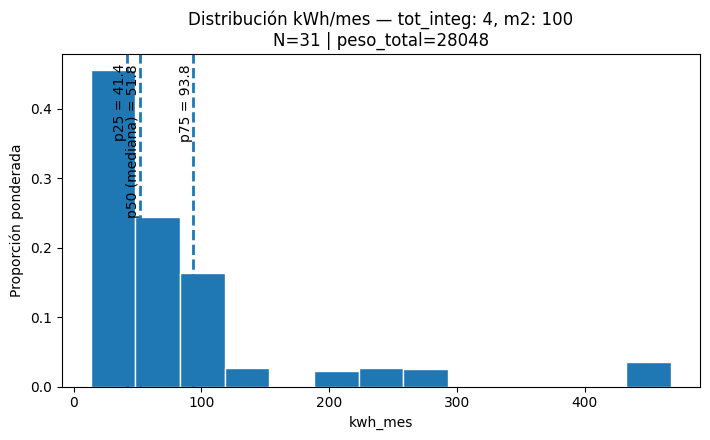

In [9]:
grafica_kwh_mes_por_m2(slp,tot_integ=2,m2_value=55)
grafica_kwh_mes_por_m2(slp,tot_integ=3,m2_value=75)
grafica_kwh_mes_por_m2(slp,tot_integ=4,m2_value=100)